# Influence functions for data mis-labelling

Both data mis-labelling and outlier detection target the same problem, they are operating on discrete and continuous values, respectively. A influence function $I(x_1, x_2) \colon \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R} $ measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$. As long as the loss function $L(x, y)$ is differentiable (or can be approximated by a surrogate objective). Imagine a simple classification problem, where $y_i \in \{1, \dots, K\}$, the goal is now to find labels which are mislabelled.

## Artificial data generation

First we generate a K-class, M-dimensional dataset using a Gaussian mixture model (GMM). This can be done by sampling $N$ data points from a discrete distribution.

In [1]:
from valuation.utils import Dataset
from sklearn.model_selection import train_test_split

import numpy as np

N = 1000
K = 2
M = 2
sigma = 0.2

gaussian_mean = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])
gaussian_cov = sigma * np.eye(M)
gaussian_chol = np.linalg.cholesky(gaussian_cov)
y = np.random.randint(K, size=N)
x = np.einsum('ij,kj->ki', gaussian_chol, np.random.normal(size=[N, M])) + gaussian_mean[y]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70)
dataset = Dataset(
    x_train,
    y_train,
    x_test,
    y_test
)

## Plotting the training and the test data

In the following we plot the training as well as the test set side by side.

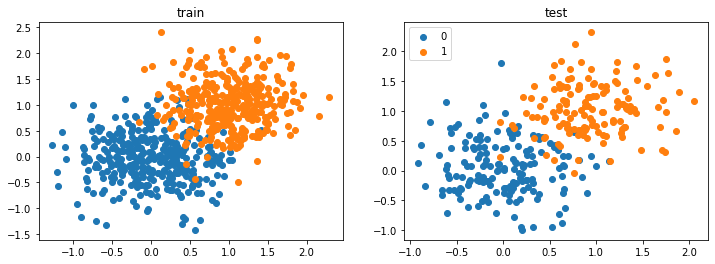

In [2]:
import matplotlib.pyplot as plt

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
num_datasets = len(datasets)
fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))

for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)

    for v in np.unique(y):
        idx = np.argwhere(y == v)
        ax[i].scatter(x[idx, 0], x[idx, 1], label=str(v))


plt.legend()
plt.show()

## Calculating linear influences using logistic regression

In this section we utilize a logistic regression model to identify wrongly labelled data samples. As a first step one needs to define a model, fit it to the data and then insert it in the influence function

In [3]:
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
from valuation.influence.general import influences
from valuation.influence.types import InfluenceTypes
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

objective = F.binary_cross_entropy
model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(M),
    objective=F.binary_cross_entropy,
    num_epochs=1000,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM,
    optimizer_kwargs={"lr": 0.01, "weight_decay": 0.01},
)
model.fit(
    dataset.x_train,
    dataset.y_train
)

train_influences = influences(
    model,
    dataset.x_train,
    dataset.y_train,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)
test_influences = influences(
    model,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)

Training loss: 0.6912875175476074
Training loss: 0.6865068078041077
Training loss: 0.6797597408294678
Training loss: 0.6766617298126221
Training loss: 0.6712059378623962
Training loss: 0.6646214723587036
Training loss: 0.6596739292144775
Training loss: 0.6606265306472778
Training loss: 0.6511961817741394
Training loss: 0.6456541419029236
Training loss: 0.6434377431869507
Training loss: 0.6344307065010071
Training loss: 0.6302980780601501
Training loss: 0.6366137266159058
Training loss: 0.6243205666542053
Training loss: 0.6178014278411865
Training loss: 0.6173613667488098
Training loss: 0.6061391830444336
Training loss: 0.6028884053230286
Training loss: 0.6141694784164429
Training loss: 0.598774790763855
Training loss: 0.5926588773727417
Training loss: 0.592788577079773
Training loss: 0.5795968174934387
Training loss: 0.5772385001182556
Training loss: 0.5930922627449036
Training loss: 0.5744900107383728
Training loss: 0.5698220729827881
Training loss: 0.5696289539337158
Training loss: 0

Training loss: 0.2217310070991516
Training loss: 0.17821970582008362
Training loss: 0.19445748627185822
Training loss: 0.26363351941108704
Training loss: 0.20284458994865417
Training loss: 0.259363055229187
Training loss: 0.22058680653572083
Training loss: 0.1768759787082672
Training loss: 0.19325564801692963
Training loss: 0.26250457763671875
Training loss: 0.2016863226890564
Training loss: 0.2584724724292755
Training loss: 0.21948479115962982
Training loss: 0.17557978630065918
Training loss: 0.1920977234840393
Training loss: 0.26141557097435
Training loss: 0.20057083666324615
Training loss: 0.25761643052101135
Training loss: 0.21842312812805176
Training loss: 0.17432920634746552
Training loss: 0.19098183512687683
Training loss: 0.26036494970321655
Training loss: 0.1994962841272354
Training loss: 0.25679340958595276
Training loss: 0.21740011870861053
Training loss: 0.17312240600585938
Training loss: 0.18990622460842133
Training loss: 0.2593511641025543
Training loss: 0.198460981249809

Training loss: 0.17319749295711517
Training loss: 0.23716852068901062
Training loss: 0.19201573729515076
Training loss: 0.14270049333572388
Training loss: 0.16316038370132446
Training loss: 0.23382623493671417
Training loss: 0.173085018992424
Training loss: 0.23708584904670715
Training loss: 0.19190186262130737
Training loss: 0.14256428182125092
Training loss: 0.1630413830280304
Training loss: 0.23371218144893646
Training loss: 0.17297671735286713
Training loss: 0.23700621724128723
Training loss: 0.19179202616214752
Training loss: 0.14243300259113312
Training loss: 0.16292667388916016
Training loss: 0.23360228538513184
Training loss: 0.17287249863147736
Training loss: 0.2369295060634613
Training loss: 0.19168609380722046
Training loss: 0.14230652153491974
Training loss: 0.1628161072731018
Training loss: 0.23349639773368835
Training loss: 0.17277218401432037
Training loss: 0.2368556559085846
Training loss: 0.19158396124839783
Training loss: 0.14218464493751526
Training loss: 0.162709534

Training loss: 0.16027699410915375
Training loss: 0.23108863830566406
Training loss: 0.1705448478460312
Training loss: 0.2351781129837036
Training loss: 0.18921546638011932
Training loss: 0.13941773772239685
Training loss: 0.16027016937732697
Training loss: 0.23108237981796265
Training loss: 0.1705394685268402
Training loss: 0.23517367243766785
Training loss: 0.18920889496803284
Training loss: 0.139410600066185
Training loss: 0.16026365756988525
Training loss: 0.2310764044523239
Training loss: 0.17053434252738953
Training loss: 0.2351694405078888
Training loss: 0.18920265138149261
Training loss: 0.1394037902355194
Training loss: 0.1602574586868286
Training loss: 0.23107075691223145
Training loss: 0.17052948474884033
Training loss: 0.23516541719436646
Training loss: 0.18919667601585388
Training loss: 0.13939733803272247
Training loss: 0.16025155782699585
Training loss: 0.23106533288955688
Training loss: 0.17052486538887024
Training loss: 0.23516157269477844
Training loss: 0.189190983772

Training loss: 0.1890852153301239
Training loss: 0.13928528130054474
Training loss: 0.16014346480369568
Training loss: 0.23096729815006256
Training loss: 0.17044517397880554
Training loss: 0.23509079217910767
Training loss: 0.18908506631851196
Training loss: 0.13928525149822235
Training loss: 0.16014333069324493
Training loss: 0.2309672087430954
Training loss: 0.17044512927532196
Training loss: 0.2350907027721405
Training loss: 0.1890849620103836
Training loss: 0.13928523659706116
Training loss: 0.16014324128627777
Training loss: 0.23096710443496704
Training loss: 0.17044506967067719
Training loss: 0.23509061336517334
Training loss: 0.18908484280109406
Training loss: 0.13928522169589996
Training loss: 0.16014312207698822
Training loss: 0.2309669554233551
Training loss: 0.17044499516487122
Training loss: 0.23509052395820618
Training loss: 0.1890847086906433
Training loss: 0.13928522169589996
Training loss: 0.16014300286769867
Training loss: 0.23096685111522675
Training loss: 0.170444935

Training loss: 0.18908318877220154
Training loss: 0.1392877846956253
Training loss: 0.16014190018177032
Training loss: 0.23096518218517303
Training loss: 0.17044442892074585
Training loss: 0.2350890189409256
Training loss: 0.18908318877220154
Training loss: 0.13928791880607605
Training loss: 0.16014191508293152
Training loss: 0.23096516728401184
Training loss: 0.17044444382190704
Training loss: 0.2350890040397644
Training loss: 0.18908318877220154
Training loss: 0.1392880082130432
Training loss: 0.16014191508293152
Training loss: 0.23096515238285065
Training loss: 0.17044444382190704
Training loss: 0.23508897423744202
Training loss: 0.18908318877220154
Training loss: 0.13928812742233276
Training loss: 0.16014191508293152
Training loss: 0.23096512258052826
Training loss: 0.17044445872306824
Training loss: 0.23508895933628082
Training loss: 0.18908315896987915
Training loss: 0.13928823173046112
Training loss: 0.16014191508293152
Training loss: 0.23096509277820587
Training loss: 0.1704444

Training loss: 0.23096401989459991
Training loss: 0.17044475674629211
Training loss: 0.23508794605731964
Training loss: 0.1890835464000702
Training loss: 0.13929633796215057
Training loss: 0.1601427048444748
Training loss: 0.23096401989459991
Training loss: 0.1704448014497757
Training loss: 0.23508796095848083
Training loss: 0.1890835464000702
Training loss: 0.13929645717144012
Training loss: 0.1601427048444748
Training loss: 0.23096399009227753
Training loss: 0.1704448163509369
Training loss: 0.23508793115615845
Training loss: 0.1890835464000702
Training loss: 0.1392965465784073
Training loss: 0.160142719745636
Training loss: 0.23096399009227753
Training loss: 0.1704448014497757
Training loss: 0.23508790135383606
Training loss: 0.1890835464000702
Training loss: 0.13929669559001923
Training loss: 0.16014273464679718
Training loss: 0.23096396028995514
Training loss: 0.1704447865486145
Training loss: 0.23508790135383606
Training loss: 0.1890835464000702
Training loss: 0.13929681479930878

Training loss: 0.13930478692054749
Training loss: 0.1601436585187912
Training loss: 0.2309628427028656
Training loss: 0.17044493556022644
Training loss: 0.23508697748184204
Training loss: 0.18908412754535675
Training loss: 0.13930490612983704
Training loss: 0.1601436734199524
Training loss: 0.2309628278017044
Training loss: 0.17044490575790405
Training loss: 0.23508697748184204
Training loss: 0.18908411264419556
Training loss: 0.13930505514144897
Training loss: 0.1601436883211136
Training loss: 0.2309628278017044
Training loss: 0.17044490575790405
Training loss: 0.23508697748184204
Training loss: 0.18908414244651794
Training loss: 0.13930515944957733
Training loss: 0.16014370322227478
Training loss: 0.2309628278017044
Training loss: 0.17044493556022644
Training loss: 0.23508694767951965
Training loss: 0.18908415734767914
Training loss: 0.13930527865886688
Training loss: 0.16014371812343597
Training loss: 0.23096278309822083
Training loss: 0.17044492065906525
Training loss: 0.2350869476

Training loss: 0.13930943608283997
Training loss: 0.1601441502571106
Training loss: 0.2309621423482895
Training loss: 0.17044487595558167
Training loss: 0.23508641123771667
Training loss: 0.18908442556858063
Training loss: 0.1393095701932907
Training loss: 0.16014418005943298
Training loss: 0.2309621423482895
Training loss: 0.17044487595558167
Training loss: 0.2350863814353943
Training loss: 0.1890844702720642
Training loss: 0.13930968940258026
Training loss: 0.16014419496059418
Training loss: 0.2309621274471283
Training loss: 0.17044487595558167
Training loss: 0.2350863814353943
Training loss: 0.18908444046974182
Training loss: 0.1393098086118698
Training loss: 0.16014420986175537
Training loss: 0.2309621125459671
Training loss: 0.17044487595558167
Training loss: 0.2350863814353943
Training loss: 0.1890844702720642
Training loss: 0.13930991291999817
Training loss: 0.16014422476291656
Training loss: 0.2309621274471283
Training loss: 0.17044486105442047
Training loss: 0.2350863665342331

Training loss: 0.23508545756340027
Training loss: 0.1890849769115448
Training loss: 0.13931751251220703
Training loss: 0.160145103931427
Training loss: 0.2309609204530716
Training loss: 0.17044466733932495
Training loss: 0.23508542776107788
Training loss: 0.189084991812706
Training loss: 0.1393176019191742
Training loss: 0.160145103931427
Training loss: 0.2309609055519104
Training loss: 0.17044469714164734
Training loss: 0.2350853979587555
Training loss: 0.1890849769115448
Training loss: 0.13931770622730255
Training loss: 0.160145103931427
Training loss: 0.2309608906507492
Training loss: 0.17044469714164734
Training loss: 0.2350853979587555
Training loss: 0.189084991812706
Training loss: 0.13931778073310852
Training loss: 0.1601451188325882
Training loss: 0.2309608906507492
Training loss: 0.17044468224048615
Training loss: 0.2350853681564331
Training loss: 0.1890849769115448
Training loss: 0.13931789994239807
Training loss: 0.1601451337337494
Training loss: 0.23096086084842682
Training

Training loss: 0.23096001148223877
Training loss: 0.17044450342655182
Training loss: 0.2350846230983734
Training loss: 0.18908537924289703
Training loss: 0.13932384550571442
Training loss: 0.1601458191871643
Training loss: 0.23095998167991638
Training loss: 0.170444518327713
Training loss: 0.2350846529006958
Training loss: 0.18908537924289703
Training loss: 0.13932393491268158
Training loss: 0.1601458340883255
Training loss: 0.23095998167991638
Training loss: 0.17044448852539062
Training loss: 0.23508460819721222
Training loss: 0.18908539414405823
Training loss: 0.13932400941848755
Training loss: 0.1601458340883255
Training loss: 0.23095998167991638
Training loss: 0.17044450342655182
Training loss: 0.2350846230983734
Training loss: 0.18908542394638062
Training loss: 0.1393241137266159
Training loss: 0.16014587879180908
Training loss: 0.23095998167991638
Training loss: 0.1704445481300354
Training loss: 0.2350846230983734
Training loss: 0.18908542394638062
Training loss: 0.13932421803474

Training loss: 0.23095956444740295
Training loss: 0.17044442892074585
Training loss: 0.23508426547050476
Training loss: 0.18908561766147614
Training loss: 0.1393270343542099
Training loss: 0.16014622151851654
Training loss: 0.23095954954624176
Training loss: 0.17044444382190704
Training loss: 0.23508426547050476
Training loss: 0.18908558785915375
Training loss: 0.13932709395885468
Training loss: 0.16014622151851654
Training loss: 0.23095954954624176
Training loss: 0.17044441401958466
Training loss: 0.23508423566818237
Training loss: 0.18908560276031494
Training loss: 0.13932719826698303
Training loss: 0.16014623641967773
Training loss: 0.23095953464508057
Training loss: 0.17044439911842346
Training loss: 0.23508423566818237
Training loss: 0.18908560276031494
Training loss: 0.139327272772789
Training loss: 0.16014623641967773
Training loss: 0.23095951974391937
Training loss: 0.17044439911842346
Training loss: 0.23508420586585999
Training loss: 0.18908561766147614
Training loss: 0.139327

Training loss: 0.16014651954174042
Training loss: 0.23095907270908356
Training loss: 0.17044425010681152
Training loss: 0.23508383333683014
Training loss: 0.18908573687076569
Training loss: 0.13932999968528748
Training loss: 0.1601465493440628
Training loss: 0.23095907270908356
Training loss: 0.17044426500797272
Training loss: 0.23508384823799133
Training loss: 0.18908575177192688
Training loss: 0.13933008909225464
Training loss: 0.1601465493440628
Training loss: 0.23095905780792236
Training loss: 0.17044425010681152
Training loss: 0.23508381843566895
Training loss: 0.18908573687076569
Training loss: 0.13933014869689941
Training loss: 0.1601465493440628
Training loss: 0.23095905780792236
Training loss: 0.1704442799091339
Training loss: 0.23508380353450775
Training loss: 0.18908575177192688
Training loss: 0.139330193400383
Training loss: 0.160146564245224
Training loss: 0.23095905780792236
Training loss: 0.17044426500797272
Training loss: 0.23508380353450775
Training loss: 0.18908575177

Training loss: 0.13933353126049042
Training loss: 0.16014692187309265
Training loss: 0.23095852136611938
Training loss: 0.1704440861940384
Training loss: 0.23508337140083313
Training loss: 0.1890859305858612
Training loss: 0.139333575963974
Training loss: 0.16014695167541504
Training loss: 0.23095852136611938
Training loss: 0.1704440861940384
Training loss: 0.23508337140083313
Training loss: 0.1890859156847
Training loss: 0.13933363556861877
Training loss: 0.16014695167541504
Training loss: 0.23095852136611938
Training loss: 0.1704440712928772
Training loss: 0.23508337140083313
Training loss: 0.18908590078353882
Training loss: 0.13933369517326355
Training loss: 0.16014695167541504
Training loss: 0.23095852136611938
Training loss: 0.1704440712928772
Training loss: 0.23508334159851074
Training loss: 0.18908590078353882
Training loss: 0.13933373987674713
Training loss: 0.16014695167541504
Training loss: 0.2309584766626358
Training loss: 0.1704440712928772
Training loss: 0.2350833117961883

Training loss: 0.2350829839706421
Training loss: 0.18908609449863434
Training loss: 0.1393364518880844
Training loss: 0.1601472795009613
Training loss: 0.23095816373825073
Training loss: 0.17044398188591003
Training loss: 0.2350829839706421
Training loss: 0.18908609449863434
Training loss: 0.13933652639389038
Training loss: 0.16014732420444489
Training loss: 0.23095816373825073
Training loss: 0.17044398188591003
Training loss: 0.2350829839706421
Training loss: 0.18908609449863434
Training loss: 0.13933655619621277
Training loss: 0.16014732420444489
Training loss: 0.23095816373825073
Training loss: 0.17044396698474884
Training loss: 0.2350829839706421
Training loss: 0.18908609449863434
Training loss: 0.13933660089969635
Training loss: 0.16014733910560608
Training loss: 0.23095813393592834
Training loss: 0.17044396698474884
Training loss: 0.2350829690694809
Training loss: 0.18908607959747314
Training loss: 0.13933660089969635
Training loss: 0.16014732420444489
Training loss: 0.2309581190

Training loss: 0.17044395208358765
Training loss: 0.23508280515670776
Training loss: 0.1890861541032791
Training loss: 0.13933786749839783
Training loss: 0.16014748811721802
Training loss: 0.2309579998254776
Training loss: 0.17044395208358765
Training loss: 0.23508280515670776
Training loss: 0.1890861690044403
Training loss: 0.1393379271030426
Training loss: 0.1601475030183792
Training loss: 0.2309579849243164
Training loss: 0.17044393718242645
Training loss: 0.23508277535438538
Training loss: 0.1890861541032791
Training loss: 0.1393379420042038
Training loss: 0.16014748811721802
Training loss: 0.2309579700231552
Training loss: 0.17044395208358765
Training loss: 0.23508280515670776
Training loss: 0.1890861690044403
Training loss: 0.13933798670768738
Training loss: 0.1601475030183792
Training loss: 0.2309579700231552
Training loss: 0.17044395208358765
Training loss: 0.23508280515670776
Training loss: 0.1890861541032791
Training loss: 0.13933801651000977
Training loss: 0.1601475030183792

Training loss: 0.16014772653579712
Training loss: 0.2309577912092209
Training loss: 0.17044389247894287
Training loss: 0.23508261144161224
Training loss: 0.18908627331256866
Training loss: 0.1393396258354187
Training loss: 0.16014772653579712
Training loss: 0.2309577763080597
Training loss: 0.17044389247894287
Training loss: 0.23508259654045105
Training loss: 0.18908628821372986
Training loss: 0.1393396556377411
Training loss: 0.1601477414369583
Training loss: 0.2309577912092209
Training loss: 0.17044392228126526
Training loss: 0.23508259654045105
Training loss: 0.18908628821372986
Training loss: 0.1393396556377411
Training loss: 0.16014772653579712
Training loss: 0.2309577614068985
Training loss: 0.17044387757778168
Training loss: 0.23508262634277344
Training loss: 0.18908628821372986
Training loss: 0.13933967053890228
Training loss: 0.1601477414369583
Training loss: 0.2309577614068985
Training loss: 0.17044387757778168
Training loss: 0.23508259654045105
Training loss: 0.1890862733125

# Plotting the mean influences of the training samples

Next we are going to calculate the mean absolute influences of the training samples and plot them.

In [4]:
mean_influences = lambda arr: np.mean(np.abs(arr.copy()), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)
train_influences.shape

(300, 700)

<Figure size 432x288 with 0 Axes>

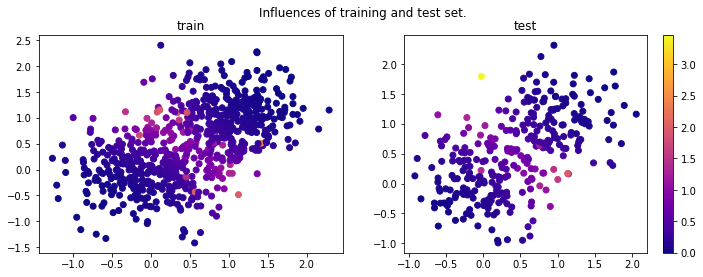

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))
mean_influences = {
    'train': mean_train_influences,
    'test': mean_test_influences
}
v_max = max(np.max(mean_train_influences), np.max(mean_test_influences))
for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)
    points = ax[i].scatter(x[:, 0], x[:, 1], c=mean_influences[dataset_name], vmin=0, vmax=v_max, cmap="plasma")

plt.suptitle("Influences of training and test set.")
plt.colorbar(points)
plt.show()


## Retraining model with shortened dataset



In [6]:
num_select_points = 1000
important_indices = np.flip(np.argsort(mean_influences))[:num_select_points]

In [7]:
dataset.x_train = dataset.x_train[important_indices]
dataset.y_train = dataset.y_train[important_indices]

In [8]:
objective = F.binary_cross_entropy
model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(M),
    objective=F.binary_cross_entropy,
    num_epochs=300,
    batch_size=64,
    optimizer=PyTorchOptimizer.ADAM,
    optimizer_kwargs={"lr": 0.001},
)
model.fit(
    dataset.x_train,
    dataset.y_train
)

Training loss: 0.6800053715705872
Training loss: 0.6785774827003479
Training loss: 0.6771517992019653
Training loss: 0.6757283210754395
Training loss: 0.6743068695068359
Training loss: 0.672887921333313
Training loss: 0.671471118927002
Training loss: 0.6700566411018372
Training loss: 0.6686446666717529
Training loss: 0.6672349572181702
Training loss: 0.665827751159668
Training loss: 0.6644229888916016
Training loss: 0.663020670413971
Training loss: 0.6616208553314209
Training loss: 0.6602236032485962
Training loss: 0.6588289737701416
Training loss: 0.6574369668960571
Training loss: 0.6560474634170532
Training loss: 0.654660701751709
Training loss: 0.6532765626907349
Training loss: 0.6518951058387756
Training loss: 0.6505163908004761
Training loss: 0.649140477180481
Training loss: 0.6477672457695007
Training loss: 0.6463969349861145
Training loss: 0.6450293064117432
Training loss: 0.6436644196510315
Training loss: 0.642302393913269
Training loss: 0.640943169593811
Training loss: 0.63958

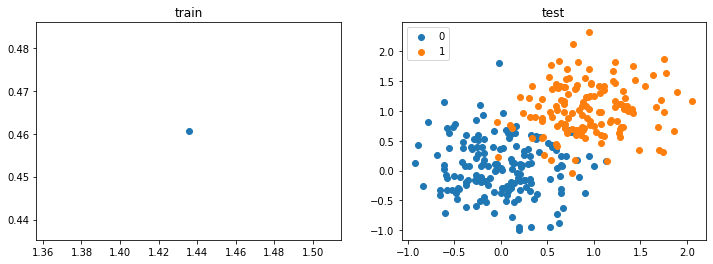

In [9]:
import matplotlib.pyplot as plt

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
num_datasets = len(datasets)
fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))

for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)

    for v in np.unique(y):
        idx = np.argwhere(y == v)
        ax[i].scatter(x[idx, 0], x[idx, 1], label=str(v))


plt.legend()
plt.show()